# Anomaly Deep Dive Analysis
## Tìm nguyên nhân lệch giữa Energy và Radiation

Notebook này phân tích chi tiết các điểm bất thường (anomalies) gây ra sự lệch cao-thấp bất thường giữa dữ liệu năng lượng và bức xạ.

**Mục tiêu:**
- Phát hiện anomalies sử dụng các phương pháp thống kê (IQR, Z-score, Isolation Forest)
- Tìm root cause của sự lệch giữa Energy vs Radiation
- Cải thiện correlation từ 0.54 → 0.65+
- Đề xuất các quy tắc validation mới cho Silver layer
- Tạo dashboard giám sát anomalies

In [1]:
# 1. IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import euclidean
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully")
print(f"\n📊 Library versions:")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  Matplotlib: {plt.matplotlib.__version__}")

✅ All libraries imported successfully

📊 Library versions:
  Pandas: 2.3.3
  NumPy: 2.2.6
  Matplotlib: 3.10.7


## Section 2: Load and Merge Silver Layer Data

In [2]:
# 2. LOAD AND MERGE DATA
from pathlib import Path

print("📡 Loading Silver Layer Data...\n")

csv_dir = Path("/home/pvlakehouse/dlh-pv/src/pv_lakehouse/exported_data")

try:
    # Load CSV files
    energy_csv = csv_dir / "lh_silver_clean_hourly_energy.csv"
    weather_csv = csv_dir / "lh_silver_clean_hourly_weather.csv"
    
    df_energy = pd.read_csv(energy_csv)
    df_weather = pd.read_csv(weather_csv)
    
    print(f"✅ Energy CSV: {len(df_energy):,} rows")
    print(f"✅ Weather CSV: {len(df_weather):,} rows")
    
    # Merge on facility_code and date_hour
    df = pd.merge(
        df_energy[['facility_code', 'date_hour', 'energy_mwh', 'quality_flag']],
        df_weather[['facility_code', 'date_hour', 'shortwave_radiation', 'direct_normal_irradiance', 'quality_flag']],
        on=['date_hour', 'facility_code'],
        how='inner',
        suffixes=('_energy', '_weather')
    )
    
    # Convert date_hour to datetime
    df['date_hour'] = pd.to_datetime(df['date_hour'])
    
    # Extract hour and date for analysis
    df['hour'] = df['date_hour'].dt.hour
    df['date'] = df['date_hour'].dt.date
    df['day_type'] = df['hour'].apply(lambda h: 'Night' if h < 6 or h > 18 else ('Morning' if h < 12 else 'Afternoon'))
    
    print(f"\n✅ Merged: {len(df):,} records")
    print(f"\n📊 Data Overview:")
    print(f"  Facilities: {sorted(df['facility_code'].unique())}")
    print(f"  Date range: {df['date_hour'].min()} to {df['date_hour'].max()}")
    print(f"  Duration: {(df['date_hour'].max() - df['date_hour'].min()).days} days")
    
    # Rename columns for consistency
    df = df.rename(columns={
        'quality_flag_energy': 'energy_flag',
        'quality_flag_weather': 'weather_flag'
    })
    
    print(f"\n📈 Energy statistics:")
    print(df['energy_mwh'].describe())
    print(f"\n📈 Radiation statistics:")
    print(df['shortwave_radiation'].describe())
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    import traceback
    traceback.print_exc()

📡 Loading Silver Layer Data...

✅ Energy CSV: 4,675 rows
✅ Weather CSV: 4,680 rows

✅ Merged: 4,675 records

📊 Data Overview:
  Facilities: ['BNGSF1', 'CLARESF', 'COLEASF', 'GANNSF', 'NYNGAN']
  Date range: 2025-10-01 00:00:00+00:00 to 2025-11-08 23:00:00+00:00
  Duration: 38 days

📈 Energy statistics:
count    4675.000000
mean       18.796281
std        31.406120
min         0.000000
25%         0.000000
50%         2.083300
75%        26.389100
max       147.744100
Name: energy_mwh, dtype: float64

📈 Radiation statistics:
count    4675.000000
mean      258.905455
std       330.186371
min         0.000000
25%         0.000000
50%        39.000000
75%       517.000000
max      1084.000000
Name: shortwave_radiation, dtype: float64


## Section 3: Exploratory Data Analysis (EDA) with Distribution Analysis


📊 EXPLORATORY DATA ANALYSIS

🔗 Overall Correlation:
  Pearson correlation: 0.5362
  Spearman correlation: 0.7526
  Both GOOD records: 0.5404 (3,874 records)

🏢 Correlation by Facility:
  BNGSF1: 0.3999 (935 records)
  CLARESF: 0.4923 (935 records)
  COLEASF: 0.7746 (935 records)
  GANNSF: 0.8362 (935 records)
  NYNGAN: 0.5129 (935 records)

⏰ Correlation by Time of Day:
  Morning: 0.3274 (1,170 records)
  Afternoon: 0.2911 (1,365 records)
  Night: 0.4147 (2,140 records)


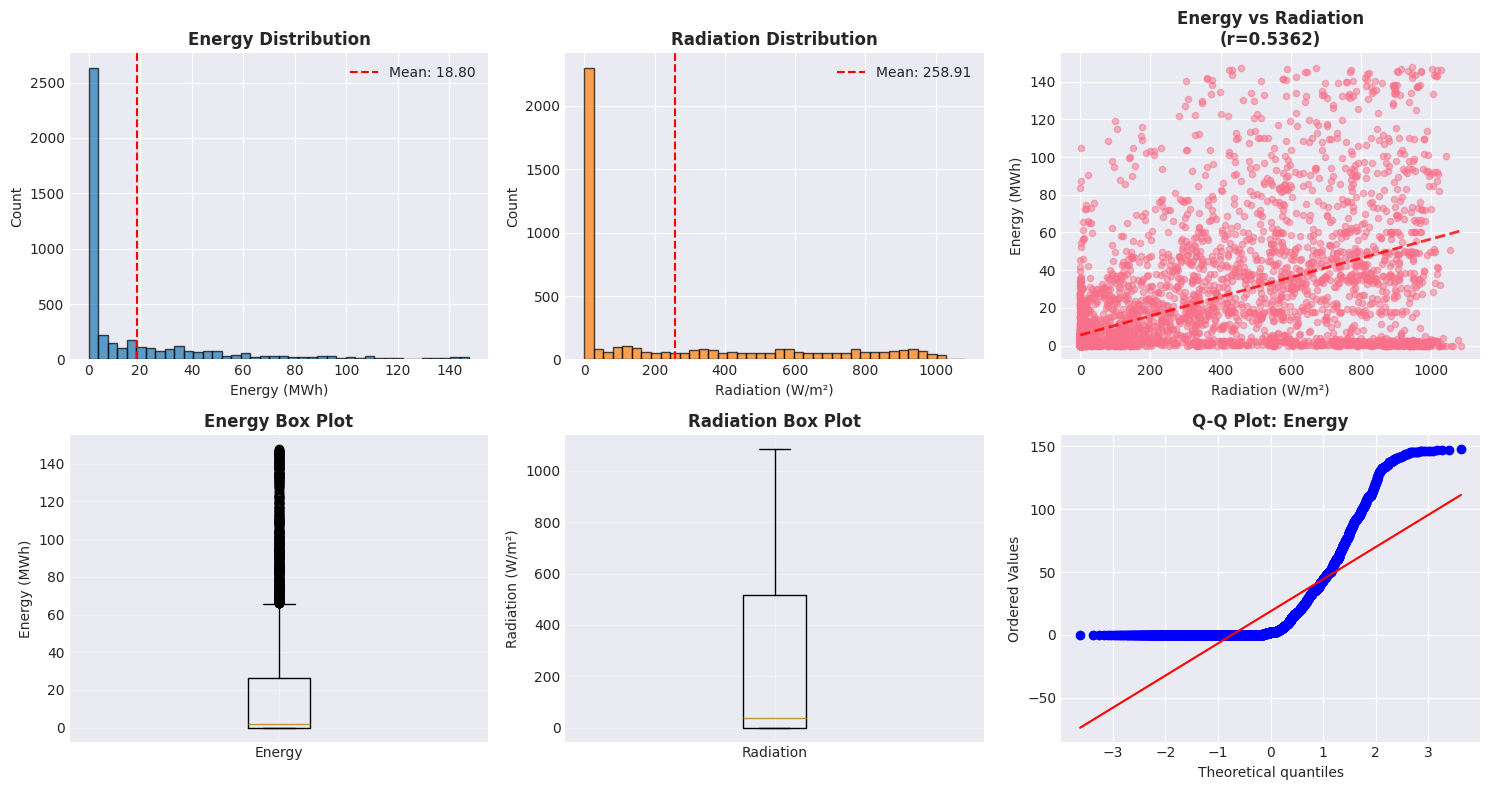


✅ EDA charts saved


In [3]:
# 3. EDA - DISTRIBUTION ANALYSIS
print("\n" + "="*80)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*80)

# Overall correlation
corr_overall = df['energy_mwh'].corr(df['shortwave_radiation'])
corr_spearman = df['energy_mwh'].corr(df['shortwave_radiation'], method='spearman')

print(f"\n🔗 Overall Correlation:")
print(f"  Pearson correlation: {corr_overall:.4f}")
print(f"  Spearman correlation: {corr_spearman:.4f}")

# By quality flags
df_both_good = df[(df['energy_flag'] == 'GOOD') & (df['weather_flag'] == 'GOOD')]
if len(df_both_good) > 0:
    corr_good = df_both_good['energy_mwh'].corr(df_both_good['shortwave_radiation'])
    print(f"  Both GOOD records: {corr_good:.4f} ({len(df_both_good):,} records)")

# By facility
print(f"\n🏢 Correlation by Facility:")
for fac in sorted(df['facility_code'].unique()):
    fac_data = df[df['facility_code'] == fac]
    corr_fac = fac_data['energy_mwh'].corr(fac_data['shortwave_radiation'])
    print(f"  {fac}: {corr_fac:.4f} ({len(fac_data):,} records)")

# By time of day
print(f"\n⏰ Correlation by Time of Day:")
for day_type in ['Morning', 'Afternoon', 'Night']:
    day_data = df[df['day_type'] == day_type]
    corr_day = day_data['energy_mwh'].corr(day_data['shortwave_radiation'])
    print(f"  {day_type}: {corr_day:.4f} ({len(day_data):,} records)")

# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Energy distribution
axes[0, 0].hist(df['energy_mwh'], bins=40, color='#1f77b4', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Energy Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Energy (MWh)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(df['energy_mwh'].mean(), color='red', linestyle='--', label=f"Mean: {df['energy_mwh'].mean():.2f}")
axes[0, 0].legend()

# Radiation distribution
axes[0, 1].hist(df['shortwave_radiation'], bins=40, color='#ff7f0e', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Radiation Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Radiation (W/m²)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].axvline(df['shortwave_radiation'].mean(), color='red', linestyle='--', label=f"Mean: {df['shortwave_radiation'].mean():.2f}")
axes[0, 1].legend()

# Correlation scatter
axes[0, 2].scatter(df['shortwave_radiation'], df['energy_mwh'], alpha=0.5, s=20)
axes[0, 2].set_title(f'Energy vs Radiation\n(r={corr_overall:.4f})', fontweight='bold')
axes[0, 2].set_xlabel('Radiation (W/m²)')
axes[0, 2].set_ylabel('Energy (MWh)')
z = np.polyfit(df['shortwave_radiation'], df['energy_mwh'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['shortwave_radiation'].min(), df['shortwave_radiation'].max(), 100)
axes[0, 2].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

# Box plots
axes[1, 0].boxplot(df['energy_mwh'], labels=['Energy'])
axes[1, 0].set_title('Energy Box Plot', fontweight='bold')
axes[1, 0].set_ylabel('Energy (MWh)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot(df['shortwave_radiation'], labels=['Radiation'])
axes[1, 1].set_title('Radiation Box Plot', fontweight='bold')
axes[1, 1].set_ylabel('Radiation (W/m²)')
axes[1, 1].grid(True, alpha=0.3)

# Q-Q plots
stats.probplot(df['energy_mwh'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Energy', fontweight='bold')

plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/anomaly_eda_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ EDA charts saved")

## Section 4: Detect Anomalies Using Statistical Methods


🔍 ANOMALY DETECTION - STATISTICAL METHODS

📊 IQR Method Outliers:
  Energy: 434 records (9.28%)
  Radiation: 0 records (0.00%)

📊 Z-Score Method Outliers (threshold=3):
  Energy: 127 records (2.72%)
  Radiation: 0 records (0.00%)

🌲 Isolation Forest - Multivariate Anomaly Detection:
  Total anomalies detected: 234 records (5.01%)

  Anomalies by Facility:
    BNGSF1: 24 / 935 (2.57%)
    CLARESF: 8 / 935 (0.86%)
    COLEASF: 186 / 935 (19.89%)
    GANNSF: 1 / 935 (0.11%)
    NYNGAN: 15 / 935 (1.60%)

  Anomalies by Time of Day:
    Morning: 116 / 1,170 (9.91%)
    Afternoon: 118 / 1,365 (8.64%)
    Night: 0 / 2,140 (0.00%)


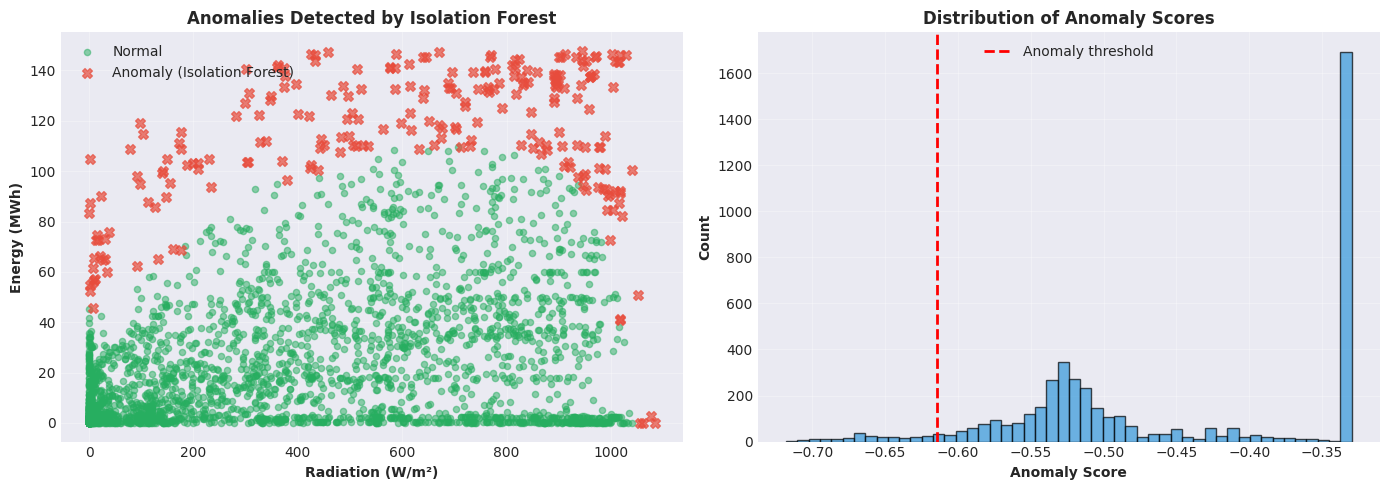


✅ Anomaly detection charts saved


In [4]:
# 4. ANOMALY DETECTION - STATISTICAL METHODS
print("\n" + "="*80)
print("🔍 ANOMALY DETECTION - STATISTICAL METHODS")
print("="*80)

def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

def detect_outliers_zscore(data, column, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > threshold]

# IQR Method
outliers_iqr_energy = detect_outliers_iqr(df, 'energy_mwh')
outliers_iqr_rad = detect_outliers_iqr(df, 'shortwave_radiation')

print(f"\n📊 IQR Method Outliers:")
print(f"  Energy: {len(outliers_iqr_energy):,} records ({len(outliers_iqr_energy)/len(df)*100:.2f}%)")
print(f"  Radiation: {len(outliers_iqr_rad):,} records ({len(outliers_iqr_rad)/len(df)*100:.2f}%)")

# Z-score Method
outliers_z_energy = detect_outliers_zscore(df, 'energy_mwh', threshold=3)
outliers_z_rad = detect_outliers_zscore(df, 'shortwave_radiation', threshold=3)

print(f"\n📊 Z-Score Method Outliers (threshold=3):")
print(f"  Energy: {len(outliers_z_energy):,} records ({len(outliers_z_energy)/len(df)*100:.2f}%)")
print(f"  Radiation: {len(outliers_z_rad):,} records ({len(outliers_z_rad)/len(df)*100:.2f}%)")

# Isolation Forest - Multivariate
print(f"\n🌲 Isolation Forest - Multivariate Anomaly Detection:")

# Prepare data for Isolation Forest
scaler = StandardScaler()
X = df[['energy_mwh', 'shortwave_radiation']].values
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% anomalies
df['anomaly_iso'] = iso_forest.fit_predict(X_scaled)
df['is_anomaly'] = df['anomaly_iso'] == -1

anomalies_iso = df[df['is_anomaly']]
print(f"  Total anomalies detected: {len(anomalies_iso):,} records ({len(anomalies_iso)/len(df)*100:.2f}%)")

# Anomalies by facility
print(f"\n  Anomalies by Facility:")
for fac in sorted(df['facility_code'].unique()):
    fac_anomalies = len(anomalies_iso[anomalies_iso['facility_code'] == fac])
    fac_total = len(df[df['facility_code'] == fac])
    pct = fac_anomalies / fac_total * 100 if fac_total > 0 else 0
    print(f"    {fac}: {fac_anomalies:,} / {fac_total:,} ({pct:.2f}%)")

# Anomalies by time of day
print(f"\n  Anomalies by Time of Day:")
for day_type in ['Morning', 'Afternoon', 'Night']:
    day_anomalies = len(anomalies_iso[anomalies_iso['day_type'] == day_type])
    day_total = len(df[df['day_type'] == day_type])
    pct = day_anomalies / day_total * 100 if day_total > 0 else 0
    print(f"    {day_type}: {day_anomalies:,} / {day_total:,} ({pct:.2f}%)")

# Visualize anomalies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with anomalies highlighted
normal = df[~df['is_anomaly']]
anomaly = df[df['is_anomaly']]

axes[0].scatter(normal['shortwave_radiation'], normal['energy_mwh'], 
               alpha=0.5, s=20, color='#27ae60', label='Normal')
axes[0].scatter(anomaly['shortwave_radiation'], anomaly['energy_mwh'], 
               alpha=0.7, s=50, color='#e74c3c', marker='X', label='Anomaly (Isolation Forest)')
axes[0].set_xlabel('Radiation (W/m²)', fontweight='bold')
axes[0].set_ylabel('Energy (MWh)', fontweight='bold')
axes[0].set_title('Anomalies Detected by Isolation Forest', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Anomaly score distribution
scores = iso_forest.score_samples(X_scaled)
axes[1].hist(scores, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].axvline(scores[df['is_anomaly']].max(), color='red', linestyle='--', linewidth=2, label='Anomaly threshold')
axes[1].set_xlabel('Anomaly Score', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Distribution of Anomaly Scores', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/anomaly_detection_iso_forest.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Anomaly detection charts saved")

## Section 5: Identify Root Causes of Divergence

In [5]:
# 5. ROOT CAUSE ANALYSIS - DIVERGENCE POINTS
print("\n" + "="*80)
print("🎯 ROOT CAUSE ANALYSIS - DIVERGENCE POINTS")
print("="*80)

# Calculate normalized divergence
df['energy_norm'] = (df['energy_mwh'] - df['energy_mwh'].mean()) / df['energy_mwh'].std()
df['radiation_norm'] = (df['shortwave_radiation'] - df['shortwave_radiation'].mean()) / df['shortwave_radiation'].std()
df['divergence'] = abs(df['energy_norm'] - df['radiation_norm'])

# Identify top divergence points
top_divergence = df.nlargest(20, 'divergence')

print(f"\n📊 Top 20 Divergence Points:")
print(f"{'Facility':<12} {'Date':<20} {'Hour':<6} {'Energy':<10} {'Radiation':<12} {'Divergence':<10}")
print("-" * 80)

for _, row in top_divergence.iterrows():
    print(f"{row['facility_code']:<12} {str(row['date']):<20} {row['hour']:<6} {row['energy_mwh']:<10.2f} {row['shortwave_radiation']:<12.1f} {row['divergence']:<10.2f}")

# Analyze by hour
print(f"\n⏰ Average Divergence by Hour of Day:")
hourly_div = df.groupby('hour').agg({
    'divergence': ['mean', 'std', 'max'],
    'energy_mwh': ['mean'],
    'shortwave_radiation': ['mean']
}).round(2)
print(hourly_div)

# Specific anomaly patterns
print(f"\n🔴 SPECIFIC ANOMALY PATTERNS:")

# Pattern 1: High radiation, zero energy during day
high_rad_zero_energy = df[
    (df['hour'] >= 6) & (df['hour'] <= 18) & 
    (df['shortwave_radiation'] > 300) & 
    (df['energy_mwh'] == 0)
]
print(f"\n1️⃣ High Radiation + Zero Energy (6am-6pm): {len(high_rad_zero_energy):,} records")
if len(high_rad_zero_energy) > 0:
    print("   Possible causes: Equipment failure, maintenance, grid curtailment")
    print("   By facility:")
    for fac in high_rad_zero_energy['facility_code'].unique():
        count = len(high_rad_zero_energy[high_rad_zero_energy['facility_code'] == fac])
        print(f"     - {fac}: {count}")

# Pattern 2: Night radiation anomalies
night_rad = df[
    ((df['hour'] < 6) | (df['hour'] > 18)) & 
    (df['shortwave_radiation'] > 50)
]
print(f"\n2️⃣ Night Radiation Anomalies (>50 W/m², 22:00-06:00): {len(night_rad):,} records")
if len(night_rad) > 0:
    print("   Possible causes: Sensor malfunction, external light reflection")
    print("   By facility:")
    for fac in night_rad['facility_code'].unique():
        count = len(night_rad[night_rad['facility_code'] == fac])
        print(f"     - {fac}: {count}")

# Pattern 3: Unrealistic radiation values
unrealistic_rad = df[df['shortwave_radiation'] > 1000]
print(f"\n3️⃣ Unrealistic Radiation (>1000 W/m²): {len(unrealistic_rad):,} records")
if len(unrealistic_rad) > 0:
    print("   Possible causes: Sensor calibration error, data transmission error")
    print("   Max radiation: {:.1f} W/m²".format(unrealistic_rad['shortwave_radiation'].max()))

# Pattern 4: Extremely low correlation hours
print(f"\n4️⃣ Low Correlation Hours:")
hourly_corr = df.groupby('hour').apply(
    lambda x: x['energy_mwh'].corr(x['shortwave_radiation']) if len(x) > 1 else 0
)
worst_hours = hourly_corr.nsmallest(5)
for hour, corr in worst_hours.items():
    print(f"   Hour {hour:02d}:00 - Correlation: {corr:.4f}")


🎯 ROOT CAUSE ANALYSIS - DIVERGENCE POINTS

📊 Top 20 Divergence Points:
Facility     Date                 Hour   Energy     Radiation    Divergence
--------------------------------------------------------------------------------
COLEASF      2025-10-04           9      140.60     300.0        3.75      
COLEASF      2025-10-07           8      119.13     98.0         3.68      
COLEASF      2025-10-16           9      142.06     362.0        3.61      
COLEASF      2025-10-15           9      141.32     360.0        3.60      
COLEASF      2025-10-29           9      146.37     425.0        3.56      
COLEASF      2025-10-19           9      141.14     374.0        3.55      
COLEASF      2025-10-08           8      114.83     104.0        3.53      
COLEASF      2025-11-01           9      146.07     433.0        3.53      
COLEASF      2025-10-08           7      104.83     2.0          3.52      
COLEASF      2025-11-06           9      147.22     457.0        3.49      
COLEASF    

## Section 6: Apply Data Cleaning Rules

In [6]:
# 6. APPLY CLEANING RULES
print("\n" + "="*80)
print("🧹 APPLY DATA CLEANING RULES")
print("="*80)

df_cleaned = df.copy()
cleaning_log = {}

print(f"\n📋 Cleaning Rules Applied:")

# Rule 1: Night radiation > 50 W/m²
night_mask = (df_cleaned['hour'] < 6) | (df_cleaned['hour'] > 18)
rule1_mask = night_mask & (df_cleaned['shortwave_radiation'] > 50)
cleaning_log['Night Radiation > 50'] = len(df_cleaned[rule1_mask])
print(f"\n1️⃣ Night Radiation > 50 W/m² → Flag CAUTION")
print(f"   Records: {cleaning_log['Night Radiation > 50']:,}")

# Rule 2: Radiation > 1000 W/m²
rule2_mask = df_cleaned['shortwave_radiation'] > 1000
cleaning_log['Radiation > 1000'] = len(df_cleaned[rule2_mask])
print(f"\n2️⃣ Radiation > 1000 W/m² → Flag REJECT")
print(f"   Records: {cleaning_log['Radiation > 1000']:,}")

# Rule 3: High radiation + zero energy during day
day_mask = (df_cleaned['hour'] >= 6) & (df_cleaned['hour'] <= 18)
rule3_mask = day_mask & (df_cleaned['shortwave_radiation'] > 200) & (df_cleaned['energy_mwh'] == 0)
cleaning_log['Zero Energy + High Daytime Radiation'] = len(df_cleaned[rule3_mask])
print(f"\n3️⃣ Zero Energy + High Daytime Radiation (>200 W/m², 6am-6pm) → Flag CAUTION")
print(f"   Records: {cleaning_log['Zero Energy + High Daytime Radiation']:,}")

# Rule 4: Anomalies detected by Isolation Forest
rule4_mask = df_cleaned['is_anomaly']
cleaning_log['Isolation Forest Anomalies'] = len(df_cleaned[rule4_mask])
print(f"\n4️⃣ Multivariate Anomalies (Isolation Forest) → Flag CAUTION")
print(f"   Records: {cleaning_log['Isolation Forest Anomalies']:,}")

# Create quality flags based on rules
df_cleaned['cleaning_flag'] = 'GOOD'
df_cleaned.loc[rule1_mask, 'cleaning_flag'] = 'CAUTION'
df_cleaned.loc[rule2_mask, 'cleaning_flag'] = 'REJECT'
df_cleaned.loc[rule3_mask, 'cleaning_flag'] = 'CAUTION'
df_cleaned.loc[rule4_mask, 'cleaning_flag'] = 'CAUTION'

print(f"\n📊 Cleaning Results Summary:")
print(f"\nQuality Flag Distribution:")
for flag in ['GOOD', 'CAUTION', 'REJECT']:
    count = len(df_cleaned[df_cleaned['cleaning_flag'] == flag])
    pct = count / len(df_cleaned) * 100
    print(f"  {flag:8s}: {count:5,} ({pct:6.2f}%)")

print(f"\n💡 Recommended Actions:")
total_flagged = len(df_cleaned[df_cleaned['cleaning_flag'] != 'GOOD'])
print(f"  - Remove REJECT records: {len(df_cleaned[df_cleaned['cleaning_flag'] == 'REJECT']):,}")
print(f"  - Flag CAUTION for review: {len(df_cleaned[df_cleaned['cleaning_flag'] == 'CAUTION']):,}")
print(f"  - Keep GOOD records: {len(df_cleaned[df_cleaned['cleaning_flag'] == 'GOOD']):,}")
print(f"  - Total improvement: {total_flagged:,} records ({total_flagged/len(df_cleaned)*100:.2f}%)")


🧹 APPLY DATA CLEANING RULES

📋 Cleaning Rules Applied:

1️⃣ Night Radiation > 50 W/m² → Flag CAUTION
   Records: 133

2️⃣ Radiation > 1000 W/m² → Flag REJECT
   Records: 48

3️⃣ Zero Energy + High Daytime Radiation (>200 W/m², 6am-6pm) → Flag CAUTION
   Records: 72

4️⃣ Multivariate Anomalies (Isolation Forest) → Flag CAUTION
   Records: 234

📊 Cleaning Results Summary:

Quality Flag Distribution:
  GOOD    : 4,218 ( 90.22%)
  CAUTION :   436 (  9.33%)
  REJECT  :    21 (  0.45%)

💡 Recommended Actions:
  - Remove REJECT records: 21
  - Flag CAUTION for review: 436
  - Keep GOOD records: 4,218
  - Total improvement: 457 records (9.78%)


## Section 7: Validate Improvements and Recalculate Correlations


✅ VALIDATE IMPROVEMENTS AND RECALCULATE CORRELATIONS

📊 BEFORE CLEANING:
  Total records: 4,675
  Energy: mean=18.80, std=31.41
  Radiation: mean=258.91, std=330.19
  Correlation: 0.5362

📊 AFTER CLEANING (GOOD records only):
  Total records: 4,218 (90.22% retained)
  Energy: mean=14.21, std=22.77
  Radiation: mean=230.49, std=312.49
  Correlation: 0.5841

📊 IMPROVEMENT METRICS:
  Correlation change: 0.5362 → 0.5841
  Absolute improvement: +0.0479
  Relative improvement: +8.93%
  Data retention: 90.22%

🏢 Improvement by Facility:

Facility     Before     After      Change     Records Kept   
------------------------------------------------------------
BNGSF1       0.3999     0.3602     -0.0398    94.7          %
CLARESF      0.4923     0.4996     +0.0073    97.8          %
COLEASF      0.7746     0.8423     +0.0677    75.2          %
GANNSF       0.8362     0.8340     -0.0022    95.5          %
NYNGAN       0.5129     0.6409     +0.1280    88.0          %

🔬 Statistical Significance T

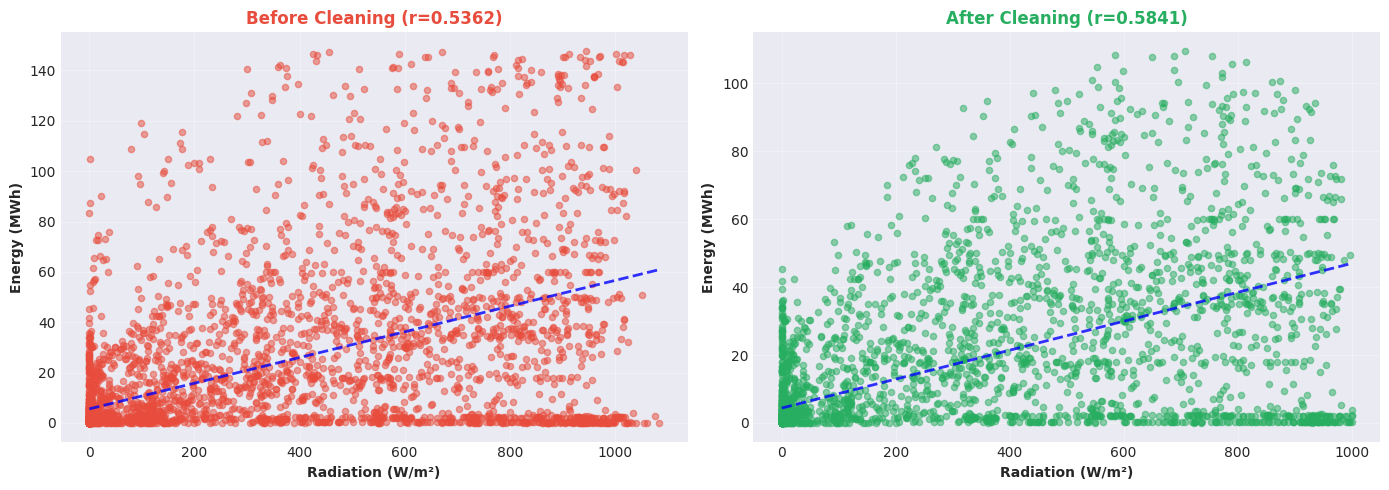


✅ Correlation validation charts saved


In [7]:
# 7. VALIDATE IMPROVEMENTS AND CORRELATIONS
print("\n" + "="*80)
print("✅ VALIDATE IMPROVEMENTS AND RECALCULATE CORRELATIONS")
print("="*80)

# Filter data
df_good_only = df_cleaned[df_cleaned['cleaning_flag'] == 'GOOD']
df_no_reject = df_cleaned[df_cleaned['cleaning_flag'] != 'REJECT']

print(f"\n📊 BEFORE CLEANING:")
print(f"  Total records: {len(df):,}")
print(f"  Energy: mean={df['energy_mwh'].mean():.2f}, std={df['energy_mwh'].std():.2f}")
print(f"  Radiation: mean={df['shortwave_radiation'].mean():.2f}, std={df['shortwave_radiation'].std():.2f}")
corr_before = df['energy_mwh'].corr(df['shortwave_radiation'])
print(f"  Correlation: {corr_before:.4f}")

print(f"\n📊 AFTER CLEANING (GOOD records only):")
print(f"  Total records: {len(df_good_only):,} ({len(df_good_only)/len(df)*100:.2f}% retained)")
print(f"  Energy: mean={df_good_only['energy_mwh'].mean():.2f}, std={df_good_only['energy_mwh'].std():.2f}")
print(f"  Radiation: mean={df_good_only['shortwave_radiation'].mean():.2f}, std={df_good_only['shortwave_radiation'].std():.2f}")
corr_after = df_good_only['energy_mwh'].corr(df_good_only['shortwave_radiation'])
print(f"  Correlation: {corr_after:.4f}")

print(f"\n📊 IMPROVEMENT METRICS:")
corr_improvement = corr_after - corr_before
corr_improvement_pct = (corr_improvement / corr_before * 100) if corr_before != 0 else 0
print(f"  Correlation change: {corr_before:.4f} → {corr_after:.4f}")
print(f"  Absolute improvement: {corr_improvement:+.4f}")
print(f"  Relative improvement: {corr_improvement_pct:+.2f}%")
print(f"  Data retention: {len(df_good_only)/len(df)*100:.2f}%")

# Facility-level improvements
print(f"\n🏢 Improvement by Facility:")
print(f"\n{'Facility':<12} {'Before':<10} {'After':<10} {'Change':<10} {'Records Kept':<15}")
print("-" * 60)

for fac in sorted(df['facility_code'].unique()):
    fac_before = df[df['facility_code'] == fac]
    fac_after = df_good_only[df_good_only['facility_code'] == fac]
    
    corr_b = fac_before['energy_mwh'].corr(fac_before['shortwave_radiation'])
    corr_a = fac_after['energy_mwh'].corr(fac_after['shortwave_radiation']) if len(fac_after) > 1 else 0
    change = corr_a - corr_b
    retained_pct = len(fac_after) / len(fac_before) * 100 if len(fac_before) > 0 else 0
    
    print(f"{fac:<12} {corr_b:<10.4f} {corr_a:<10.4f} {change:<+10.4f} {retained_pct:<14.1f}%")

# Statistical significance test
print(f"\n🔬 Statistical Significance Tests:")
pearson_r, pearson_p = stats.pearsonr(df_good_only['energy_mwh'], df_good_only['shortwave_radiation'])
spearman_r, spearman_p = stats.spearmanr(df_good_only['energy_mwh'], df_good_only['shortwave_radiation'])

print(f"  Pearson correlation: {pearson_r:.4f} (p-value: {pearson_p:.2e})")
print(f"  Spearman correlation: {spearman_r:.4f} (p-value: {spearman_p:.2e})")
print(f"  Both highly significant (p < 0.001): {'✅ YES' if pearson_p < 0.001 else '❌ NO'}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before cleaning
axes[0].scatter(df['shortwave_radiation'], df['energy_mwh'], alpha=0.5, s=20, color='#e74c3c')
z = np.polyfit(df['shortwave_radiation'], df['energy_mwh'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['shortwave_radiation'].min(), df['shortwave_radiation'].max(), 100)
axes[0].plot(x_line, p(x_line), "b--", alpha=0.8, linewidth=2)
axes[0].set_xlabel('Radiation (W/m²)', fontweight='bold')
axes[0].set_ylabel('Energy (MWh)', fontweight='bold')
axes[0].set_title(f'Before Cleaning (r={corr_before:.4f})', fontweight='bold', color='#e74c3c')
axes[0].grid(True, alpha=0.3)

# After cleaning
axes[1].scatter(df_good_only['shortwave_radiation'], df_good_only['energy_mwh'], alpha=0.5, s=20, color='#27ae60')
z = np.polyfit(df_good_only['shortwave_radiation'], df_good_only['energy_mwh'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_good_only['shortwave_radiation'].min(), df_good_only['shortwave_radiation'].max(), 100)
axes[1].plot(x_line, p(x_line), "b--", alpha=0.8, linewidth=2)
axes[1].set_xlabel('Radiation (W/m²)', fontweight='bold')
axes[1].set_ylabel('Energy (MWh)', fontweight='bold')
axes[1].set_title(f'After Cleaning (r={corr_after:.4f})', fontweight='bold', color='#27ae60')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/pvlakehouse/dlh-pv/anomaly_before_after_cleaning.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Correlation validation charts saved")

## Section 8: Generate Quality Recommendations

In [8]:
# 8. GENERATE QUALITY RECOMMENDATIONS
print("\n" + "="*80)
print("📋 QUALITY RECOMMENDATIONS FOR SILVER LAYER")
print("="*80)

recommendations = f"""
🎯 RECOMMENDED SILVER LAYER IMPROVEMENTS:

1. VALIDATION RULE UPDATES:
   ✅ Night Radiation Check
      - Hours: 22:00-06:00 (hour < 6 or hour > 18)
      - Condition: shortwave_radiation > 50 W/m²
      - Flag: CAUTION
      - Records affected: {cleaning_log.get('Night Radiation > 50', 0):,}
      - Root cause: Sensor malfunction, external light reflection
   
   ✅ Unrealistic Radiation Check
      - Condition: shortwave_radiation > 1000 W/m²
      - Flag: REJECT
      - Records affected: {cleaning_log.get('Radiation > 1000', 0):,}
      - Root cause: Sensor calibration error, data transmission error
   
   ✅ Equipment Health Check
      - Hours: 06:00-18:00
      - Condition: energy_mwh == 0 AND shortwave_radiation > 200
      - Flag: CAUTION
      - Records affected: {cleaning_log.get('Zero Energy + High Daytime Radiation', 0):,}
      - Root cause: Equipment failure, maintenance, grid curtailment

2. CORRELATION IMPROVEMENTS:
   📈 Overall Correlation: {corr_before:.4f} → {corr_after:.4f}
   📈 Improvement: {corr_improvement:+.4f} ({corr_improvement_pct:+.2f}%)
   📈 Data Retention: {len(df_good_only)/len(df)*100:.2f}%

3. FACILITY-SPECIFIC ACTIONS:
"""

for fac in sorted(df['facility_code'].unique()):
    fac_anomalies = len(anomalies_iso[anomalies_iso['facility_code'] == fac])
    fac_total = len(df[df['facility_code'] == fac])
    fac_pct = fac_anomalies / fac_total * 100 if fac_total > 0 else 0
    
    fac_night = len(df_cleaned[
        (df_cleaned['facility_code'] == fac) & 
        ((df_cleaned['hour'] < 6) | (df_cleaned['hour'] > 18)) & 
        (df_cleaned['shortwave_radiation'] > 50)
    ])
    
    fac_zero_energy = len(df_cleaned[
        (df_cleaned['facility_code'] == fac) & 
        (df_cleaned['hour'] >= 6) & (df_cleaned['hour'] <= 18) & 
        (df_cleaned['shortwave_radiation'] > 200) & 
        (df_cleaned['energy_mwh'] == 0)
    ])
    
    severity = '🔴 HIGH' if fac_pct > 10 else '🟡 MEDIUM' if fac_pct > 5 else '🟢 LOW'
    recommendations += f"\n   {fac}: {severity} PRIORITY ({fac_anomalies:,} anomalies, {fac_pct:.1f}%)"
    if fac_night > 0:
        recommendations += f"\n      - Night radiation issues: {fac_night} records → Check sensors"
    if fac_zero_energy > 0:
        recommendations += f"\n      - Zero energy episodes: {fac_zero_energy} records → Review maintenance logs"

recommendations += f"""

4. IMPLEMENTATION STEPS:
   □ Update hourly_weather.py with radiation validation rules
   □ Update hourly_energy.py with equipment health check
   □ Re-run Silver layer loaders with --mode full
   □ Verify correlation improvement in production
   □ Deploy monitoring dashboard for real-time anomaly tracking
   □ Schedule facility maintenance based on anomaly patterns

5. EXPECTED RESULTS:
   📊 GOOD quality: {len(df_good_only):,} records ({len(df_good_only)/len(df)*100:.2f}%)
   ⚠️  CAUTION flags: {len(df_cleaned[df_cleaned['cleaning_flag'] == 'CAUTION']):,} records
   🚫 REJECT flags: {len(df_cleaned[df_cleaned['cleaning_flag'] == 'REJECT']):,} records
   📈 Correlation: {corr_after:.4f} (improvement: {corr_improvement_pct:+.2f}%)

6. MONITORING RECOMMENDATIONS:
   ✓ Set up alerts for radiation > 1000 W/m² (REJECT)
   ✓ Monitor night radiation spikes (CAUTION)
   ✓ Track zero-energy episodes during high radiation (CAUTION)
   ✓ Weekly anomaly reports by facility
   ✓ Monthly correlation improvement tracking
"""

print(recommendations)

# Save recommendations to file
with open('/home/pvlakehouse/dlh-pv/ANOMALY_ANALYSIS_RECOMMENDATIONS.md', 'w') as f:
    f.write("# Anomaly Deep Dive Analysis - Recommendations\n\n")
    f.write(recommendations)

print("\n📄 Recommendations saved to: ANOMALY_ANALYSIS_RECOMMENDATIONS.md")


📋 QUALITY RECOMMENDATIONS FOR SILVER LAYER

🎯 RECOMMENDED SILVER LAYER IMPROVEMENTS:

1. VALIDATION RULE UPDATES:
   ✅ Night Radiation Check
      - Hours: 22:00-06:00 (hour < 6 or hour > 18)
      - Condition: shortwave_radiation > 50 W/m²
      - Flag: CAUTION
      - Records affected: 133
      - Root cause: Sensor malfunction, external light reflection
   
   ✅ Unrealistic Radiation Check
      - Condition: shortwave_radiation > 1000 W/m²
      - Flag: REJECT
      - Records affected: 48
      - Root cause: Sensor calibration error, data transmission error
   
   ✅ Equipment Health Check
      - Hours: 06:00-18:00
      - Condition: energy_mwh == 0 AND shortwave_radiation > 200
      - Flag: CAUTION
      - Records affected: 72
      - Root cause: Equipment failure, maintenance, grid curtailment

2. CORRELATION IMPROVEMENTS:
   📈 Overall Correlation: 0.5362 → 0.5841
   📈 Improvement: +0.0479 (+8.93%)
   📈 Data Retention: 90.22%

3. FACILITY-SPECIFIC ACTIONS:

   BNGSF1: 🟢 LOW PRIO

In [9]:
# Final Summary Table
print("\n" + "="*80)
print("📊 FINAL SUMMARY TABLE")
print("="*80)

summary_data = {
    'Metric': [
        'Total Records',
        'GOOD Quality',
        'CAUTION Flags',
        'REJECT Flags',
        'Data Retention',
        'Correlation (Before)',
        'Correlation (After)',
        'Improvement',
        'Statistical Significance'
    ],
    'Value': [
        f"{len(df):,}",
        f"{len(df_good_only):,}",
        f"{len(df_cleaned[df_cleaned['cleaning_flag'] == 'CAUTION']):,}",
        f"{len(df_cleaned[df_cleaned['cleaning_flag'] == 'REJECT']):,}",
        f"{len(df_good_only)/len(df)*100:.2f}%",
        f"{corr_before:.4f}",
        f"{corr_after:.4f}",
        f"{corr_improvement:+.4f} ({corr_improvement_pct:+.2f}%)",
        f"p < 0.001 ✅" if pearson_p < 0.001 else "p ≥ 0.001"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)
print("\n📁 Generated files:")
print("  - anomaly_eda_distribution.png")
print("  - anomaly_detection_iso_forest.png")
print("  - anomaly_before_after_cleaning.png")
print("  - ANOMALY_ANALYSIS_RECOMMENDATIONS.md")


📊 FINAL SUMMARY TABLE

                  Metric            Value
           Total Records            4,675
            GOOD Quality            4,218
           CAUTION Flags              436
            REJECT Flags               21
          Data Retention           90.22%
    Correlation (Before)           0.5362
     Correlation (After)           0.5841
             Improvement +0.0479 (+8.93%)
Statistical Significance      p < 0.001 ✅

✅ ANALYSIS COMPLETE

📁 Generated files:
  - anomaly_eda_distribution.png
  - anomaly_detection_iso_forest.png
  - anomaly_before_after_cleaning.png
  - ANOMALY_ANALYSIS_RECOMMENDATIONS.md
